# Test détection de signature 

<font color = 'red'> **Kernel pdf** </font>
    
**Notes sur l'installation des librairies**

**pdf2image**:\
Pour lire un pdf avec OpenCv il faut d'abord le transformer en jpg ou jpeg avec la fonction `convert_from_path` de la librairie `pdf2image`
(doc: https://stackoverflow.com/questions/61832964/how-to-convert-pdf-into-image-readable-by-opencv-python).
Cependant, pour pouvoir utiliser `convert_from_path`, il faut installer `poppler` pour Windows en suivant le lien https://github.com/oschwartz10612/poppler-windows/releases/ (lien indiqué dans le tuto : https://github.com/Belval/pdf2image).

Une fois sur site indiqué par le lien de téléchargement, cliquer sur la version `Release-23.01.0-0.zip` et placer le téléchargement dans le répertoire de votre choix. Dé-zipper le dossier intitulé `poppler-23.01.0` et créer une variable `poppler_path` qui vaut: `chemin du répertoire poppler-23.01.0\\Library\\bin`. Par exemple, j'ai placé mon dossier `poppler-23.01.0` dans le répertoire `utilities` défini par le chemin `C:\Users\A3193307\Groupe BPCE\CEMP - Data & Décisionnel - Data Science\Analyse Documents\1_Programme_Lila\utilities`. Ainsi ma variable `poppler_path` vaudra : `poppler_path  = "C:\\Users\\A3193307\\Groupe BPCE\\CEMP - Data & Décisionnel - Data Science\\Analyse Documents\\1_Programme_Lila\\utilities\\poppler-23.01.0\\Library\\bin"` (penser à doubler les `\` pour python).



**signature-detect**:\
J'ai installé le package `signature-detect` (tuto: https://github.com/EnzoSeason/signature_detection/blob/main/demo.ipynb) avec pip sans problème mais ensuite, ce package utilisait `ImageMagick` que je n'ai pas pu installer car l'ordi de la banque me le bloquait. Donc au final, j'ai regardé plus en détail le package `signature-detect` et j'ai vu qu'il utilisait `ImageMagick` seulement pour transformer les pdfs en images dans le cas où on lui rentre un pdf. Donc j'ai copié tout le package `signature-detect` et retiré toutes les fonctions concernant les pdfs et donc maintenant j'utilise mon package `signature-detect` customisé qui n'a plus besoin de `ImageMagick`. En revanche, il faut donc fournir en entrée une image et donc au préalable avoir transformé les pdfs en image (jpg ou jpeg) avec `pdf2image`.

In [1]:
# Variables globales & chemins absolus
# ------------------------------------
#----- Chemin du répertoire de travail
PATH = "C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila"

#----- Chemin des données
PATH_DATA = PATH + "/data"
# document LEA
PATH_DATA_LEA_P = PATH_DATA + "/LEA/papier" #signatures papiers
PATH_DATA_LEA_N = PATH_DATA + "/LEA/numerique" #signatures numériques
# document EAI
PATH_DATA_EAI_P = PATH_DATA + "/EAI/papier" #signatures papiers
PATH_DATA_EAI_N = PATH_DATA + "/EAI/numerique" #signatures numériques

#----- Chemin des scripts python .py
PATH_UTILS =  PATH + "/utilities"
#----- Chemin du poppler pour la fonction convert_from_path de la librairie OpenCV
poppler_path  = PATH_UTILS +'/poppler-23.01.0/Library/bin'

In [2]:
# Librairies nécessaires
# ------------------------------------
#---- Système
import os

#---- Calculs 
import numpy as np
import math

#---- Graphes 
import matplotlib.pyplot as plt

#---- Traitement des PDFs
import PyPDF2 #traitement des pdf
import cv2 #traitement d'image (jpg)
import PIL #traitement d'image (jpg)
from pdf2image import convert_from_path #transformation pdf en jpg

#---- signature-detect
os.chdir(PATH_UTILS) #signature_detect est dans le dossier utilities
from signature_detect.loader import Loader
from signature_detect.extractor_v2 import Extractor ###
from signature_detect.cropper import Cropper
from signature_detect.judger_v2 import Judger

#---- signature-extractor (je pourrai supprimer ensuite)
from skimage import measure, morphology
from skimage.measure import regionprops
from skimage.color import label2rgb ####

#---- supprimer les bords noirs des images 
from skimage.filters import threshold_local
import argparse
import imutils

#---- signature numérique
import fitz #pip install pymupdf

ModuleNotFoundError: No module named 'signature_detect.loader'

## LEA

### Documents scannés

On commence par la détection de signature sur les documents LEA scannés. Nous aurons un traitement différent si le document a été scanné ou si la signature est électronique. En effet, dans le cas des signatures électroniques, la signature est trop petite pour être détectée par l'algorithme.

Les documents LEA n'ont pas un nombre de pages fixe. La signature se situe sur la dernière page du document. Cependant, il faudra  identifier au préalable la page contenant la signature car il ne s'agit pas toujours de la dernière page selon comment le document a été scanné (par exemple, identifier avec tesseract un texte "Signature" pour identifier la page présentant la signature).

Attention, il se peut que des documents soient scannés à l'envers. Il faudra trouver un moyen d'identifier ces cas et de les corriger. 
_________________________
_________________________
1) certaines images ne sont pas bien débruitées donc le mask est cahotique : C'est bon j'ai débruité l'image auparavant et donc on utilie plus Loader de signature-detect mais une autre fonction qui me débruite l'image.

2) il y a 2 signature dans l'image, il faut arriver à n'en détecter qu'une : OK j'ai crop l'image ce qui permet de ne détecter que une signature mais aussi ne mieux détecter la signature.

3) il faut peut-être retirer les lignes verticales et horizontales, sinon, l'algo trouve le cadre et ne détecte pas la signature. On veut pouvoir supprimer le cadre: Avec les étapes 1 et 2 plus besoin

4) Ne détecte pas les signatures trop petites qui correspondent souvent à des signatures électroniques.

5) dans le cas où il n'y a pas d'image, la variable `results` à une longueur de 0 et donc signature ne fonctionne pas. Mais si results est nulle alors on peut se dire que il n'y a pas de signature. Il faut donc juste ajouter un `if`.

_________________________
_________________________
le 007015026 est une signature électronique très petite et donc ça ne prend pas en compte la signature. Par contre, quand j'ai récupéré le pdf, il y avait marqué "signature papier". Donc peut-être qu'il me faudra une méthode différente pour la signature papier et la signature électronique et que ma méthode puisse différencier si le pdf est signé papier ou numériquement.
Après vérif, toutes les signatures électroniques sont petites. 

sur le 007333320, je crois qu'ils ont échangé signature de la banque et signature client. Je ne pourrai pas faire la différence pour le moment. -> Oui mais c'est pas si grave car si la banque a signé c'est bien que le client a signé je pense.

Pour le 007417781, la signature n'est pas dans l'onglet "signature du titulaire" mais dans l'onglet "signature du représentant légal en précisant nom et prénom". Donc attentien à bien prendre un cadre qui prend en compte les 2 encadrés. \
En plus, le pdf a été scanné à l'envers, donc la dernière page est la première est vice-versa donc au lieu de prendre la dernière page, il faudrait avec tesseract arriver à déterminer la page signature, là où il y a marqué "Signature" car il se peut que ce ne soit pas le seul pdf dans ce cas.

détection de contours ne marche pas sur 007308023 car les contours ne sont pas assez bien définis, même si je débruite l'image et qu'nsuite je fait une erosion pour foncer les contours, ils ne sont toujours pas bien définis car la signature présente elle même des lignes verticales qu'il détecte comme des contours. Donc on peut faire un système de vote : détection de la signature en ayant détecté le contour au préalable et en ayant recadré l'image.
_________________________
_________________________

OpenCv text détection : https://pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

Detect Roated page in pdf : https://stackoverflow.com/questions/34515674/how-to-detect-a-rotated-page-in-a-pdf-document-in-python. Ca n'a pas l'air facile en fait. Mon idée est d'essayer de lire le texte avec Tesseract. Si ce que je lis n'est pas intelligible, essayer de rotationer la page et de lire le texte à nouveau. 

Autre librairie pour détecter les signatures : https://morioh.com/p/944003547b6c. Ca détecte les pixels qui se suivent donc ne vas pas détecter les signatures écrites espacées. Mais je peux peut-être l'utiliser comme autre méthode pour faire un vote.  

_________________________
_________________________

Pour avoir une meilleure détection, il faudrait arriver à couper la moitié de la page qui ne contient pas la signature. Cependant si j'ai un pdf scanné à l'envers, je vais supprimer la partie d'intéret. 

Donc:\
étape 1): voir si le pdf a été rotationé à 90 degrés en comparant largueur et longueur. Si oui, rotationner le pdf (peu importe si au final il se situe ou non dans le bon sens ou à 180 degrès)\
étape 2): découper l'image en 2 et calculer quelle zone est la plus remplie (= contient le plus de pixels noirs). Supprimer la zone la moins remplie. 


Autre méthode : détecter le texte avec OpenCv et/ou Tesseract, puis le supprimer

text detection with openCV : 
https://itsourcecode.com/free-projects/python-projects/opencv-python-text-detection-with-source-code/
(we have to download a pre-trained model)

### Chargement pdf

In [3]:
# Récupération du jeu de donnée
# ------------------------------------
def load_pdf(pdf_name,pdf_path,poppler_path):
    """
    Cette fonction permet de charger le pdf au format
    PIL.PpmImagePlugin.PpmImageFile.

    Input:
    -----
    - pdf_name (string): nom du pdf (avec l'extension). 
      Ex: si on a 123.pdf alors pdf_name='123.pdf'.
    - pdf_path (string): chemin du pdf 
    - poppler_path (string): chemin du poppler     

    Ouput:
    -----
    - pages (liste de PIL.PpmImagePlugin.PpmImageFile): liste 
      contenant les pages du pdf.   

    ========================= Notes ==========================
    Nous aurons besoin par la suite d'utiliser la librairie OpenCv. 
    Or, pour lire un pdf avec OpenCv il faut d'abord le transformer en jpg ou jpeg avec la 
    fonction convert_from_path de la librairie pdf2image 
    (doc: https://stackoverflow.com/questions/61832964/how-to-convert-pdf-into-image-readable-by-opencv-python). 
    Cependant, pour pouvoir utiliser convert_from_path, il faut installer poppler pour Windows en suivant 
    le lien https://github.com/oschwartz10612/poppler-windows/releases/ 
    (lien indiqué dans le tuto : https://github.com/Belval/pdf2image).

    Une fois sur site indiqué par le lien de téléchargement, cliquer sur la version 
    Release-23.01.0-0.zip et placer le téléchargement dans le répertoire de votre choix. 
    Dé-zipper le dossier intitulé poppler-23.01.0 et créer une variable poppler_path qui vaut: 
    chemin du répertoire poppler-23.01.0\\Library\\bin. 
    Par exemple, j'ai placé mon dossier poppler-23.01.0 dans le répertoire utilities défini par le chemin :
    C:\\Users\\AXXXXX\\Destop\\utilities.
    Ainsi ma variable poppler_path vaudra : 
    poppler_path  = "C:\\Users\\AXXXXX\\Destop\\utilities\\poppler-23.01.0\\Library\\bin" 
    (penser à doubler les \ pour python).
    ==========================================================
    """
    # On se place dans le dossier des pdfs 
    os.chdir(pdf_path) 
    # Récupération des pages du pdf
    pages = convert_from_path(pdf_path + "/" + pdf_name, poppler_path=poppler_path)    
    return pages

In [4]:
path_data = PATH_DATA_LEA_P
os.chdir(path_data) 
!ls

006061477_black_contour.PNG
006061477_black_contour_small.PNG
006956080.pdf
006956080_removed.pdf
006961477.pdf
006969920.pdf
007308023.pdf
007325270.pdf
007333320.pdf
007417781.pdf
007418530.pdf
007538249.pdf
008120289.pdf


In [5]:
pdf = load_pdf("006956080.pdf",path_data,poppler_path)

In [6]:
def show_image(img):
    """
    Cette fonction permet d'afficher une image sous forme 
    d'un graphique matplotlib.
    
    Input:
    -----
    - img (PIL.PpmImagePlugin.PpmImageFile): image à afficher
    
    Output:
    ------
    - Graphique de l'image.    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

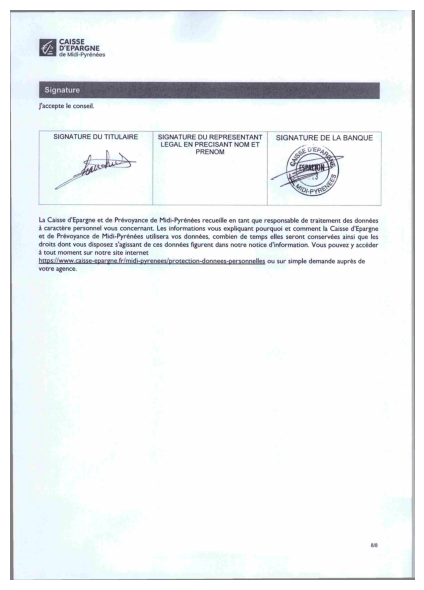

In [7]:
# Sélection de la page contenant la signature 
# (à travailler)
# ------------------------------------
"""
Référence:
---------
- transformation d'une image du format PIL.Image au format np.array :
  https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format
"""
im = pdf[-1] 
# Transformation de l'image du format PIL.Image au format np.array
im = np.array(im)  
show_image(im)

In [21]:
# Sauvegarde de l'image pour création d'un Template
# pour l'utilisation avec Alteryx
# ------------------------------------
"""from PIL import Image
im_save = Image.fromarray(im) #transforme le array en image PIL
#im_save = im_save.convert('L') #convertit l'image PIL en niveau de gris
im_save.save("template_lea.pdf")"""

In [9]:
# travailler avec une image au contour noir.
# ------------------------------------
"""os.chdir(path_data) 
im = cv2.imread("006061477_black_contour.PNG")

# Transformation de l'image du format PIL.Image au format np.array
im = np.array(im)  
show_image(im)"""

'os.chdir(path_data) \nim = cv2.imread("006061477_black_contour.PNG")\n\n# Transformation de l\'image du format PIL.Image au format np.array\nim = np.array(im)  \nshow_image(im)'

### Retirer contour noir

In [8]:
def order_points(pts):
    """
    Cette fonction trie une liste de 4 coordonnées qui sera ordonnée
    telle que le premier élément de la liste soit en haut à gauche,
    le deuxième élément en haut à droite, le troisième en bas à droite
    et le quatrième en bas à gauche. 
    
    Input:
    ------
    - pts (list): liste de 4 coordonnées. Ex: pts = array([[30., 27.],
                                                           [29., 41.],
                                                           [44., 42.],
                                                           [44., 27.]])
    Output:
    -------
    - rect (list): liste de 4 coordonnées triées. 
    
    Reference:
    ---------
    - code tiré de :
      https://github.com/ahmetozlu/signature_extractor/blob/feature-doc_scanner_sign_extrator/sample_project/dewapper.py
    - autre inspiration : 
      https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
    """
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    
    """
    Cette fonction permet de retirer la perspective d'une image.
    >>> utilise la fonciton order_points().
    
    ================================= Notes =================================
    On trie les contours de l'image avec la fonction order_points().
    On calcule ensuite la largueur et la hauteur de l'image qui peut contenir 
    de la perspective.
    Puis, on définit le bords de la nouvelle image sans perspective. 
    On calcule la matrice de transformation avec cv2.getPerspectiveTransform()
    en lui fournissant en argument les bords d'origine et les bords sans perspective 
    calculés. Enfin, on applique cv2.warpPerspective() qui permet de retirer la 
    perspective. 
    =========================================================================

    Input:
    ------
    - image (np.array): image pour laquelle retirer la perspective.
    - pts (list): liste des 4 bords de l'image. Ex: pts = array([[30., 27.],
                                                                 [29., 41.],
                                                                 [44., 42.],
                                                                 [44., 27.]])    
    Output:
    -------
    - warped (np.array): image pour laquelle on a retiré la perspective.
    
    Reference:
    ---------
    - code tiré de : 
      https://github.com/ahmetozlu/signature_extractor/blob/feature-doc_scanner_sign_extrator/sample_project/dewapper.py
    - autre inspiration :
      https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
    """
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
  
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    # flags=cv2.INTER_CUBIC: pour de ne pas dégrader l'image en appliquant la fonction.
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight), flags=cv2.INTER_CUBIC)

    # return the warped image
    return warped

def dewarp_image(image):
    """
    Cette fonction permet de supprimer les bords noirs d'une image  
    lorsque celle-ci a été scannée. 
    >>> utilise la fonction four_point_transform() qui utilise elle même 
        la fonction order_points(). 
        
    Input:
    ------
    - image (np.array): image couleur (ou en niveau de gris) pour laquelle supprimer
      les bords noirs.
    
    Output:
    -------
    - warped (np.array): image pour laquelle on a supprimé les contours. 
    
    ================================= Notes =================================
    Bref détail du fonctionnement de la fonction : 
    Redimensionne l'image couleur d'entrée, la convertit en niveau de gris et la floute avec cv2.GaussianBlur.
    Puis on applique cv.Canny pour détecter atomatiquement les contours/bords de tous les éléments de l'image. 
    Chaque contour est un vecteur de points (x,y): [[x1,y1],[x2,y2],...,[xn,yn]]. 
    La fonction cv2.Canny possède deux paramètres upper et lower. Tous les contours qui ne sont pas compris 
    entre ces 2 seuils ne seront pas considérés comme de vrais contours. Les seuils lower et upper sont 
    calculés avec un paramètre sigma et la médiane de l'intensité des pixels de l'image. 
    Les contours trouvés sont ensuite triés par ordre décroissant et on ne conserve que les 5 plus grands. 
    On itère sur les 5 contours : on calcule le périmètre du contour puis on lisse et approxime le contour 
    avec une courbe. Nous obtenons un nouveau contours lissé également défini par un vecteur de points (x,y). 
    Lorsque nous trouvons un contours avec 4 cotés et que le périmètre de celui-ci est suffisament grand, 
    il s'agit du contour de l'image entière et l'on renvoie donc l'image à l'intérieur de ce contour à l'aide
    de la fonction four_point_transform() qui permet de renvoyer une image sans perspective en appliquant les
    fonctions cv2.getPerspectiveTransform() et  cv2.warpPerspective().   
    
    On a supprimé les bords noirs de l'image.
    =========================================================================
    
    Reference:
    ---------
    - fonction dewarper.py :
      https://github.com/ahmetozlu/signature_extractor/blob/feature-doc_scanner_sign_extrator/sample_project/dewapper.py
    - tuto qui a inspiré dewarper.py
      https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
    """
    # get input image ration to keep best output resolution quality
    ratio = image.shape[0] / 500.0
    # copy source image for filter operations
    orig = image.copy()
    # resize the input image
    image = imutils.resize(image, height = 500) 

    # convert rgb input image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # floute image 
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # sigma parameter is used for automatic Canny edge detection
    sigma=0.33

    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    # détection de tous les contours de l'image (texte et signature)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    # tous les bords qui ne sont pas compris entre lower et uppper 
    # ne sont pas considérés comme des bords.
    edged = cv2.Canny(image, lower, upper) 

    # find contours. Chaque contour est un vecteur de points. 
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # trie les contours par odre décroissant: prend les 5 contours les plus grands
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    # loop over the contours
    for c in cnts:
        # calcule le périmètre du contour
        peri = cv2.arcLength(c, True)
        # Lisse et approxime le contour et retourne des points (x,y) définissant le nouveau contour.
        # Fonctionne pour les cas où les contours présentent des arêtes prononcées.
        approx = cv2.approxPolyDP(c, 0.02 * peri, True) #params: contour, approximation accuracy, closed contour 

        # si l'on trouve des contours avec 4 cotés il peut s'agit d'une bordure.
        # dans ce cas, on 
        if (len(approx) == 4):
            screenCnt = approx
            # apply the four point transform for book dewarping
            warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)            
            break #on quitte la boucle for. Conserve la denière valeur de peri

    # périmètre n'est pas trop petit ie si il s'agit bien du 
    # contour de l'image entière, on renvoie l'image sans les
    # bordures noires. 
    if peri < 1e3:
        warped = orig

    return warped

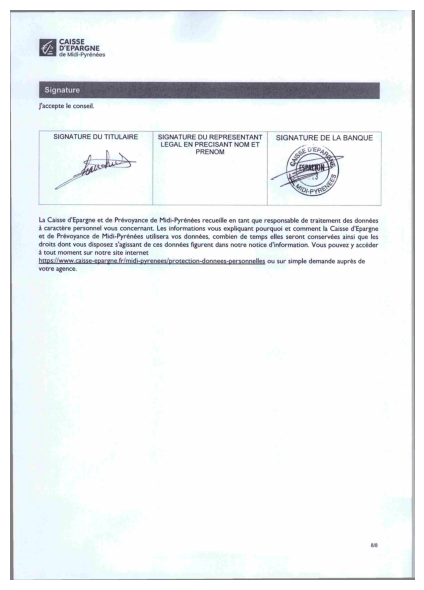

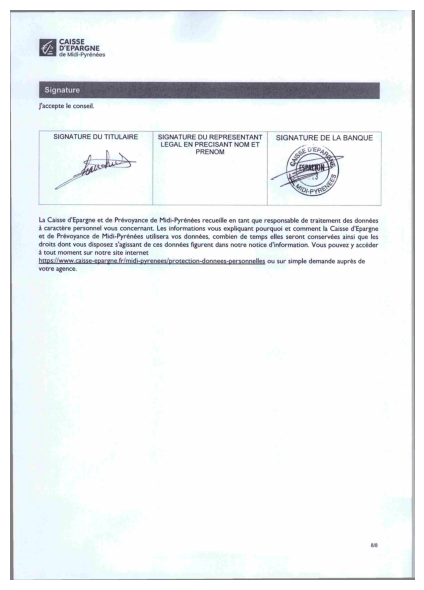

In [9]:
im_warped = dewarp_image(im)
show_image(im)
show_image(im_warped)

### Rotation & découpage grossier

On sait que la signature se trouve à peu près toujours dans le même cadre si le pdf a été bien scanné. Donc on va redimensionner l'image pour que la méthode trouve + facilement la signature par la suite.

In [10]:
def rotate_cut_image(im):
    """
    Cette fonction rotationne l'image dans le sens horaire 
    si celle ci est sous le format paysage. 
    De plus, la fonction coupe l'image en deux dans le sens de la hauteur 
    et calcule le nombre de pixels sombres (supérieurs à 128) sur les deux
    demies-parties de l'image. La partie ayant le plus de pixels sombres 
    est la partie contenant la signature et est renvoyée.
    Ansi, si l'image est rotationnée de 180 degrés par rapport à la position
    de lecture, la partie de la signature sera tout de même sélectionée.
    
    Input:
    ------
    - im (np.array): image à découper/rotationner.
    
    Ouput:
    ------
    - selected_im (np.array): image transformée.
    """
    # hauteur et largueur de l'image
    #-- cas image couleur:
    if len(im.shape) == 3:
        height, width,_  = im.shape
    #-- cas image N&B
    else:
        height, width  = im.shape

    # Si l'image est en format paysage, on la rotation 
    # en format portrait dans le sens horaire 
    if height < width:
        im = cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)
    
    # On coupe l'image en deux parties dans le sens de la hauteur
    im_upp = im[:height//2,:] #partie haute de l'image 
    im_low = im[-height//2:,:] #partie basse de l'image

    # On compte le nombre de pixels noir sur chaque demi-portion de l'image
    # 128 = 255/2 = gris
    n_upp = np.count_nonzero(im_upp <= 128) #nombre de piwels noirs sur la partie haute de l'image
    n_low = np.count_nonzero(im_low <= 128) #nombre de piwels noirs sur la partie basse de l'image

    # On retourne uniquement la demi-portion contenant le plus de pixels noirs
    if n_upp > n_low:
        selected_im = im_upp
    else:
        selected_im = im_low
    
    return selected_im

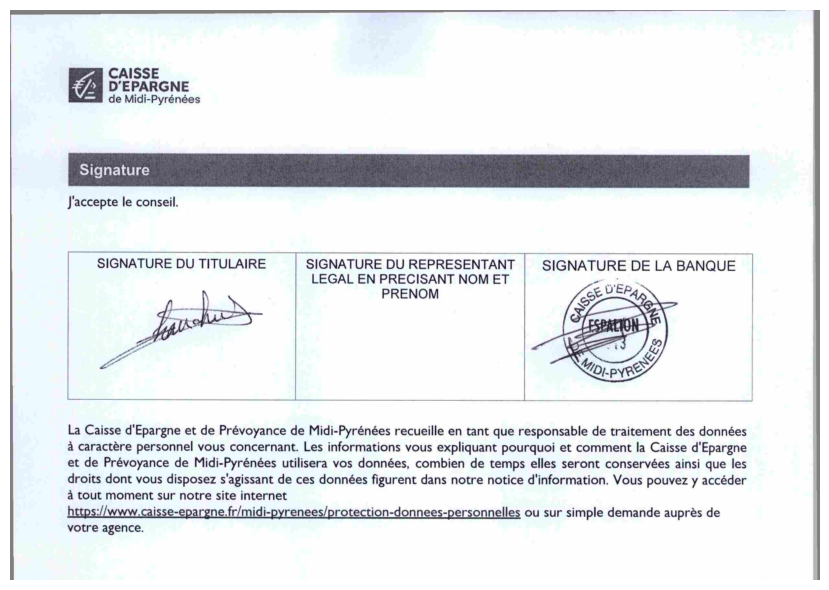

In [11]:
selected_im = rotate_cut_image(im_warped)

# ===============================
#selected_im = im_warped 
# ===============================

show_image(selected_im)

### Débruitage 

In [12]:
# Améliore la qualité de l'image pour la détection de contours.
# -------------------------------------------
def denoise_image(im):
    """
    Cette fonction permet de débruiter une image mal scannée.

    Input:
    -----
    - im (np.array): image que l'on veut débruiter

    Ouput:
    ------
    - im_thresh (np.array): image débruitée

    =========================== Notes ============================
    On commence par convertir l'image en niveau de gris pour pouvoir appliquer 
    n'importe quel seuillage avec OpenCV. 

    On applique ensuite un suillage Adaptatif (Adaptive Thresholding). 
    Le seuillage Adaptatif est plus précis qu'un seuillage binaire et est utile si 
    les conditions d'éclairage d'une image varient d'une zone à l'autre.
    Il détermine le seuil d'un pixel suà partir d'une petite région autour de celui-ci
    et permet d'obtenir différents seuils pour différentes régions d'une même image.
    Pour chaque pixel, le seuillage adaptatif examine son voisinage en utilisant une fenêtre de 
    taille (block_size x block_size). La valeur du seuil pour chaque pixel est une somme pondérée 
    par la gaussienne des valeurs de voisinage moins une constante C.
    Si la valeur du pixel est supérieure à la valeur du seuil elle est fixée à la valeur max.
    ==============================================================

    Référence:
    ----------
    - Améliore la qualité d'un pdf : 
      https://medium.com/analytics-vidhya/enhance-a-document-scan-using-python-and-opencv-9934a0c2da3d
    """
    # Mettre l'image en gris pour appliquer n'importe quel openCV thresholding par la suite 
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # Appliquation du seuillage sur l'image
    im_thresh = cv2.adaptiveThreshold(im, #image on which to apply the threshold
                                   255,  # maximum value assigned to pixel values exceeding the threshold
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # gaussian weighted sum of neighborhood
                                   cv2.THRESH_BINARY,  # thresholding type
                                   9,  # block size (5x5 window)
                                   10)  # constant

    return im_thresh

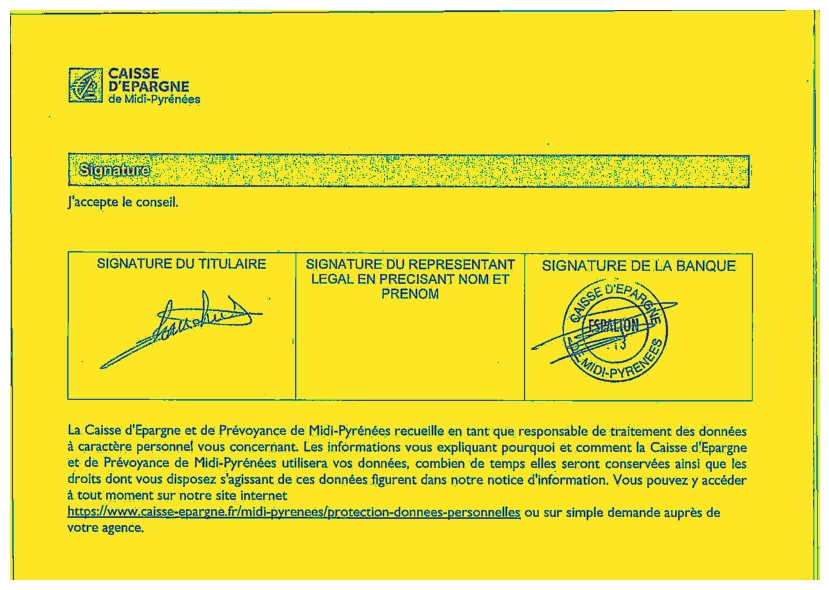

[  0 255]


In [13]:
im_thresh = denoise_image(selected_im)
show_image(im_thresh)
print(np.unique(im_thresh))

### Rotation fine

In [14]:
def extract_horiz_lines(image):
    """
    Cette fonction prend en argument une image et retourne
    une image contenant seulement les lignes horizontales.
    
    Input:
    -----
    - image (np.array): image pour laquelle extraire les
      lignes horizontales
      
    Output:
    -------
    - im_horiz (np.array): image contenant uniquement
      les contours horizontaux.
    
    Reference:
    ---------
    - algo de détection de contours:
      https://medium.com/coinmonks/a-box-detection-algorithm-for-any-image-containing-boxes-756c15d7ed26    
    """
    im = image.copy()
    #----- Invert the image
    img_bin = 255-im 

    #----- Kernels definition
    # Defining a kernel length
    # (je ne sais pas pourquoi on divise par 80 mais ça marche)
    kernel_length = np.array(im).shape[1]//80 
    # A horizontal kernel of (kernel_length x 1), which will help to detect all the horizontal line from the image.
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))

    #----- Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, horiz_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, horiz_kernel, iterations=3)
    # inverser l'image pour qu'elle retrouve ces couleurs d'origine
    im_horiz = 255 - horizontal_lines_img
    
    return im_horiz

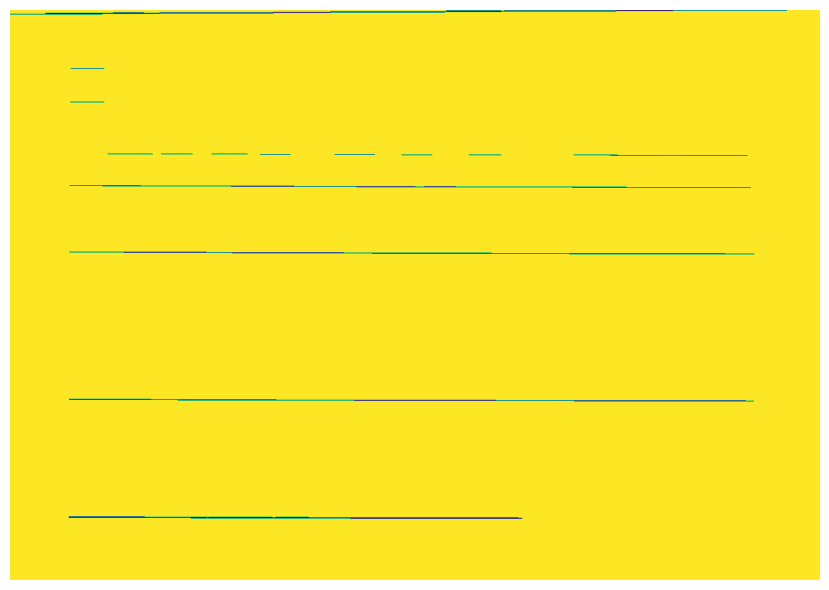

[  0 255]


In [15]:
im_horiz = extract_horiz_lines(im_thresh)
show_image(im_horiz)
print(np.unique(im_horiz))

In [16]:
def rotate_im(image, angle):
    """
    Cette fonction permet de rotationner une image 
    d'un certain angle, sans ronger les contours lors
    de la rotation.
    
    Input:
    -----
    - image (np.array): image à rotartionner
    - angle (float): angle en dregrés de la rotation.
    
    Output:
    -------
    - im_rot (np.array): image rotationée correctement.
    
    Reference:
    ----------
    - rotation "correcte" de l'image:
      https://pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    """
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix, then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    im_rot = cv2.warpAffine(image, M, (nW, nH), borderValue=(255,255,255),
                            flags = cv2.INTER_NEAREST, borderMode = cv2.BORDER_CONSTANT)
    return im_rot

In [17]:
def rotate_to_horiz(image,verbose:bool=False):
    """
    Cette fonction rotationne l'image de sorte que les lignes horizontales
    de l'image soient bien horizontales (angle 0 degrés). 
    >>> Utilise les fonctions extract_horiz_lines() pour avoir une image avec les lignes 
    horizontales uniquement et rotate_im() pour rotationner correctement l'image.
    
    ============================== Notes ==============================
    On extrait les contours horizontaux de l'image "im" avec extract_horiz_lines()
    et on obtient "im_horiz".
    Puis on trouve les lignes verticales de l'image "im_horiz" avec cv2.Canny
    et cv2.HoughLinesP. On obtient les coordonées des points (a,b) définissant chaque
    ligne de l'image : on a une liste de [[x_a,y_a,x_b,y_b]]. 
    On itère sur chaque ligne et on calcule l'angle entre chaque ligne
    et l'horizontale avec math.atan2. On obtient une liste d'angles.
    On calcule l'angle moyen des angles qui sont "proches de l'angle médian". 
    On fait pivoter l'image en fonction de l'angle moyen trouvé à l'aide de 
    la fonction rotate_im(). 
    ===================================================================
    
    Input:
    -----
    - image (np.array): image à rotationer.
    - verbose (bool): si True, affiche des images et précisions.
    
    Output:
    -------
    - im_rot (np.array): image correctement rotationée.
    
    Reference:
    ----------
    - rotation d'une image selon ses lignes horizontales
      https://stackoverflow.com/questions/39752235/python-how-to-detect-vertical-and-horizontal-lines-in-an-image-with-houghlines-w
      https://stackoverflow.com/questions/67684060/rotate-image-to-align-features-with-x-axis-in-opencv-python
  """
    im = image.copy()
    # image réduite à ces lignes horizontales :
    im_horiz = extract_horiz_lines(im)
    
    # Trouve les bords de l'image
    edges = cv2.Canny(im_horiz,50,150,apertureSize = 3)

    # HoughLinesP: Transform used to detect straight lines.
    minLineLength=100
    lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,
                            lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)
    #lines = liste ou chaque élément de la liste vaut: [[x_a,y_a,x_b,y_b]] définissant la ligne entre les points (a,b) 

    angles = []  # List of line angles.
    n_lines,_,_ = lines.shape
    for i in range(n_lines):

        # Coordonées des lignes
        x_a = lines[i][0][0]; y_a = lines[i][0][1]
        x_b = lines[i][0][2]; y_b = lines[i][0][3]

        #==================
        if verbose:
            # Pour pouvoir tracer sur l'image pour vérification
            im_horiz2 = im_horiz.copy() 
            # Draw the line for testing :
            cv2.line(im_horiz2, 
                     pt1 = (x_a, y_a), #start point
                     pt2 = (x_b, y_b), #end point
                     color = (0, 0, 255), 
                     thickness = 3, 
                     lineType = cv2.LINE_AA) 
        #==================

        # Compute the angle of the line.
        #math.atan2 = arc tangente du quotient des 2 arguments
        dx = x_b - x_a ; dy = y_b - y_a
        ang = (180/np.pi)*math.atan2(dy,dx) 
        angles.append(ang)
        
    # Convert angles to NumPy array.
    angles = np.array(angles)  
    
    # Remove outliers and... 
    lo_val, up_val = np.percentile(angles, (40, 60))  # Get the value of lower and upper 40% of all angles (mean of only 10 angles)
    # ...compute the mean of all angles
    mean_ang = np.mean(angles[np.where((angles >= lo_val) & (angles <= up_val))])
    
    #==================
    if verbose: 
        print("Lignes horizontales trouvées :")
        show_image(im_horiz2)
        print(f'mean_ang = {mean_ang}')
    #==================
    
    # rotationne l'image correctement 
    im_rot = rotate_im(im, mean_ang)

    # remet l'image en noir et blanc
    #t,im_rot = cv2.threshold(im_rot,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    t,im_rot = cv2.threshold(im_rot,10,255,cv2.THRESH_BINARY)

    # fonce en peu l'image
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    #im_rot = cv2.erode(im_rot, kernel, iterations=1)
    
    return im_rot

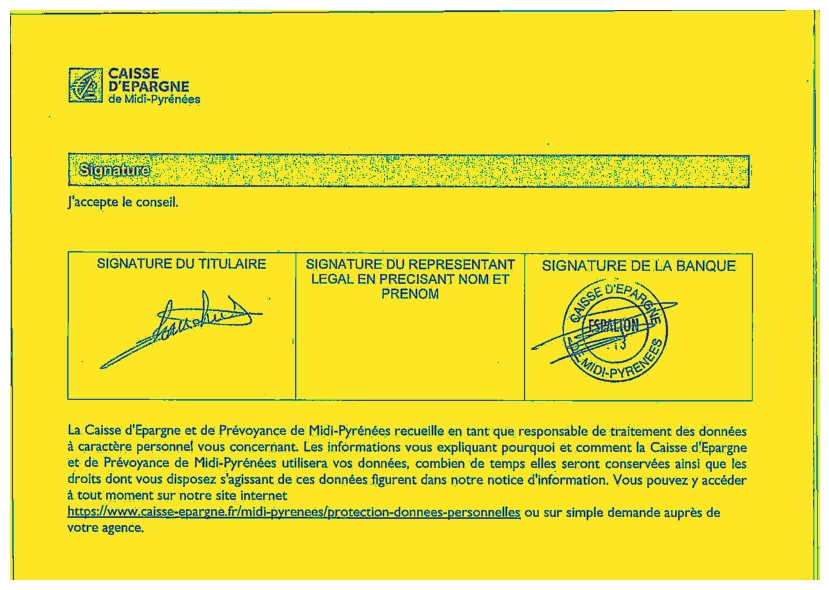

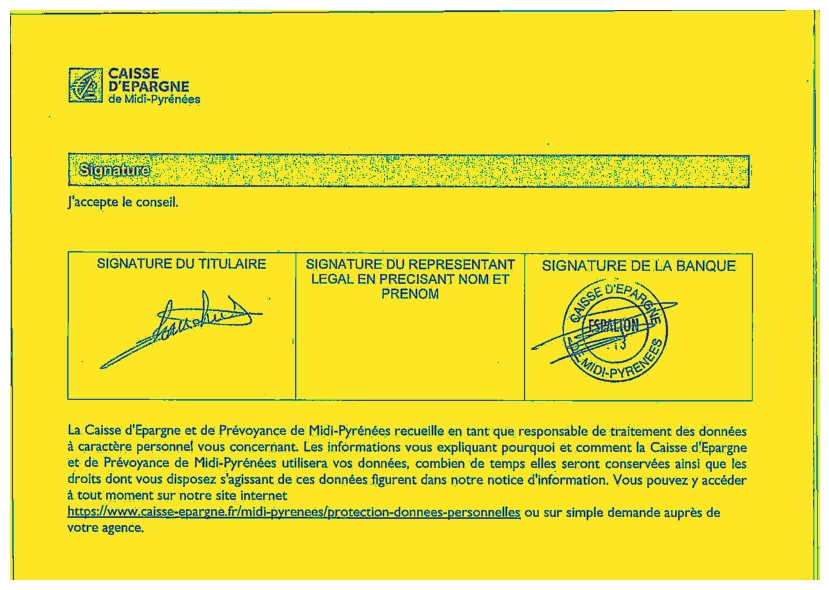

In [18]:
im_rot = rotate_to_horiz(im_thresh,verbose=False)
show_image(im_thresh)
show_image(im_rot)

### Détection des contours de la boîte

https://medium.com/coinmonks/a-box-detection-algorithm-for-any-image-containing-boxes-756c15d7ed26

**find_contours**

La première étape à effectuer lorsque nous travaillons sur un problème de reconnaissance d'objets dans une image est le prétraitement de l'image. Dans notre cas, le prétraitement consiste à extraire l'endroit où se trouve l'information. Après avoir extrait l'emplacement, nous pourrons exécuter des algorithmes de détection sur l'image.

Un des problèmes encontrés pour la détection de signature est que l'algorithme n'arrive pas bien à détecter des objets situés dans des tableaux ou boîtes. Or, pour le document LEA, la signature du client se trouve dans un encadré. Nous utilisons donc la fonction implémentée par ([1]) pour détecter et extraire les boîtes. Nous appliquerons ensuite les algorithmes de détection de signature sur chaque boîte extraite.

Fonctionnement rapide de cet algorithme :

L'algorithme ([1]) utilse les transformations morphological de la librairie OpenCV. 

Au préalable, l'image a été débruitée et coupée.

Nous appliquons ensuite une opération d'Erosion avec un noyau rectangulaire pour foncer les countours de l'image seuillée. *Pour l'Erosion, un noyau se déplace sur l'image. Pour chaque région couverte par le noyau, la valeur des pixels de la région est remplacée par la valeur minimale des pixels de la région.* L'Erosion grossit les zones sombres de l'image et amincit les zones claires.Ceci permettra à la détection de contour de mieux fonctionner. 

L'Erosion est l'opération contraire de la Dilation. *Pour la Dilation, un noyau se déplace sur l'image. Pour chaque région couverte par le noyau, la valeur des pixels de la région est remplacée par la valeur maximale des pixels de la région.* La Dilation grossit les zones sombres de claires et amincit les zones sombres. 

Les couleurs de l'image sont inversées. Pour détecter les boîtes dans l'image, nous définissons 2 noyaux rectangulaires dont la longueur est basée sur la longueur de l'image. Le premier noyau vertical de taille (1xkernel_length) permettra de détecter les lignes verticales de l'image. Le deuxième noyau horizontal de taille (kernel_lengthx1) permettra de détecter les lignes horizontales de l'image. \
Une erosion suivie dilation sont appliquées sur l'image avec les noyaux vartical et horizontal. Ceci permet de supprimer du bruit et d'obtenir deux images : l'une contenant les lignes de l'image et l'autre les colonnes.

Les deux images sont ajoutées ce qui nous permet de visualiser uniquement les boîtes présentes sur l'image. L'image est à nouveau inversée, retrouvant ces couleurs d'origine. Un seuillage Otsu (méthode de suillage qui permet de déterminer la valeur du seuil automatiquement) est ensuite appliqué pour foncer les boîtes qui ont été éclaircies avec l'ajout des deux images verticales et horizontales. Enfin, l'algorithme de détection de countour findContours de openCV est appliqué. Les contours sont ensuite triés par taille décroissante. 

Enfin, on itère sur chaque contour et on trouve à partir des contours la localisation des boîtes. Si une boîte répond à des critères de taille définis au préalable, nous renyons son contenu. 

Il se peut que cet algorithme de détection de contour ne fonctionne pas bien si le pdf scanné est de mauvaise qualité. Dans ce cas, si aucune boîte n'est trouvée, nous renvoyons l'image d'origine.

[1]: https://medium.com/coinmonks/a-box-detection-algorithm-for-any-image-containing-boxes-756c15d7ed26

In [19]:
def sort_contours(cnts, method="left-to-right"):
    """
    Cette fonction trie les contours entrés 
    en argument. 
    """
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [20]:
def find_contours(im,w_low=1200,w_upp=1600,h_low=200,h_upp=400):
    """
    Cette fonction permet de détecter et de renvoyer le contenu 
    des boîtes présentes sur l'image. Si aucune boîte n'est détectée,
    l'image d'origine est renvoyée. 
    >>> L'image d'entrée doit être au moins passée par la fonction 
        denoise_image().

    Input:
    ------
    - im (PIL.PpmImagePlugin.PpmImageFile): image pour laquelle détecter les contours. 
    - w_low,w_upp (int): valeurs minimale et maximale pour la largeur de 
      la boite à retourner.
    - h_low,h_upp (int): valeurs minimale et maximale pour la hauteur de 
      la boite à retourner.

    Output:
    ------
    - im_box (np.array): contenu de la boîte sélectionnée
    - found_box (bool): si True, l'algorithme a trouvé une boîte
      qui correspondait aux tolérances (w_low,w_upp,h_low,h_upp).
    - box_prop (list): les propriétés [x,y,w,h] du contour de la boîte. 
      Attention, (x,y) est le coin en haut à gauche de la boîte (et pas le centre).
      Les variables w et h sont la largueur et hauteur de la boîte.

    ======================== Notes ========================
    To detect the boxes, we use morphological operations from OpenCV.
    For that We will define rectangular kernel with the length based 
    on the width of the image. We will define two kernels : 
    1) Kernel to detect horizontal lines. 
    2) Kernel to detect vertical lines.

    After defining kernels we will do morphological operations to detect 
    the vertical and horizontal lines of the image. We obtain 2 images: 
    one with vertical lines only and the other with horizontal lines only.

    Now we will add these two images. This will have only boxes and the information 
    written in the box will be erased. So we can accurately detect the boxes and no 
    noise will occur for false box extraction.

    Now we will apply OpenCv findContours() method to this image. This will find all the boxes
    and we will sort them from top to bottom. For sorting the contours we will use the 
    function provided by [*]. We will use top-to-bottom approach.

    Now loop over all the contours, find the location of all the boxes and crop the
    part which has a rectangle and save it into one folder.
    =======================================================

    Reference:
    ----------
    - algo détection de contours:
      https://medium.com/coinmonks/a-box-detection-algorithm-for-any-image-containing-boxes-756c15d7ed26
    - trier les contours :
      [*] https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/.
    """
    #----- Invert the image
    img_bin = 255-im 

    #----- Kernels definition
    # Defining a kernel length
    # (je ne sais pas pourquoi on divise par 80 mais ça marche)
    kernel_length = np.array(im).shape[1]//80 
    #A vertical kernel of (1 x kernel_length), which will detect all the verticle lines from the image.
    verti_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length x 1), which will help to detect all the horizontal line from the image.
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3x3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    #----- Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verti_kernel, iterations=3) 
    verticle_lines_img = cv2.dilate(img_temp1, verti_kernel, iterations=3)

    #----- Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, horiz_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, horiz_kernel, iterations=3)

    #----- Add vertical and horizontal images
    # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
    alpha = 0.5; beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)

    #---- Application d'un seuillage pour foncer à nouveau les traits de l'image
    #     qui ont été éclaircis avec l'addition des deux images
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) 

    #----- Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #----- Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

    #----- Pour chaque contour, on retrouve la boîte et sont contenu. 
    #      Si la boîte est conforme à certaines tolérances entrées par 
    #      l'utilisateur, elle est retournée. 
    found_box = False #indique si on a trouvé une boîte
    for c in contours: #itérations sur les contours
        # Returns the location and width, height for every contour
        x, y, w, h = cv2.boundingRect(c) 
        
        # If the box height and width is within certain tolerances, it is returned
        if (w_low < w and w < w_upp and h_low < h and h < h_upp):
            box_prop = [x, y, w, h]
            found_box = True #on une boîte qui correspond aux critères
            im_box = im[y:y+h, x:x+w] #renvoie de la boîte
            
    if not(found_box): #si aucune boîte n'est trouvée, on renvoie l'image d'origine
        im_box = im
        h,w=im_box.shape
        x=0;y=0
        box_prop = [x, y, w, h]

    return im_box,found_box,box_prop

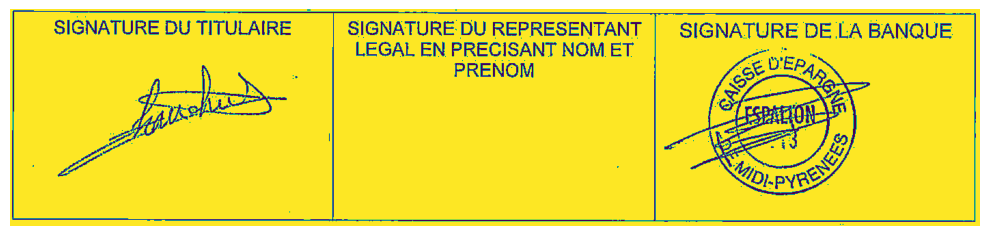

found_box: True


In [21]:
im_box,found_box,box_prop = find_contours(im_rot)
show_image(im_box)
print("found_box:",found_box)

### Recadrage image

une fois la box extraite, virer le tour de la box puis appliquer un algo de détection de contour pour détecter la signature 

In [22]:
def divide_by_3(im,found_box=False):
    """
    Cette fonction coupe l'image d'entrée en 3 dans le sens 
    de la longueur. 
    Si l'argument found_box=True, cela veut dire que la fonction
    find_contours() a pu détecter les contours de la signature. 
    Dans ce cas, pour chacune des 3 images obtenues, on retire 
    l'entête selon des paramètres fixés dans la fonction
    
    Input:
    ------
    - im (np.array): image d'entrée à découper
    - found_box (bool): indique si des boîtes ont 
      été détectées afin de retirer l'entête.
    
    Ouput:
    ------
    - sig_titulaire (np.array): première partie de l'image découpée
    - sig_rep_legal (np.array): deuxième partie de l'image découpée
    """    
    height,width = im.shape
        
    sig_titulaire = im[:,:width//3]
    sig_rep_legal = im[:,width//3:width - width//3]
    sig_banque = im[:,-width//3:]

    if found_box:
        sig_titulaire = sig_titulaire[45:,:]
        sig_rep_legal = sig_rep_legal[100:,:]   
     
    return sig_titulaire,sig_rep_legal

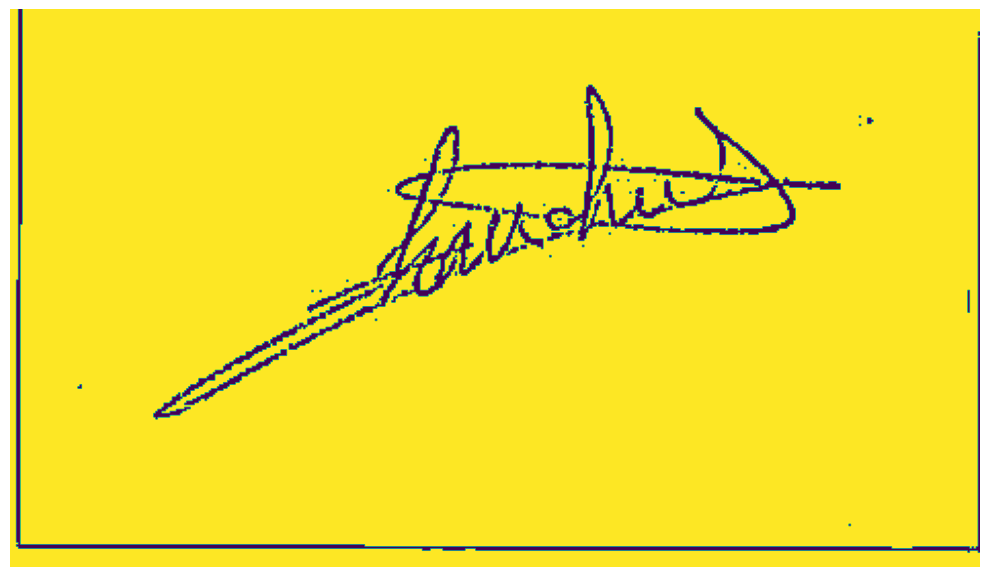

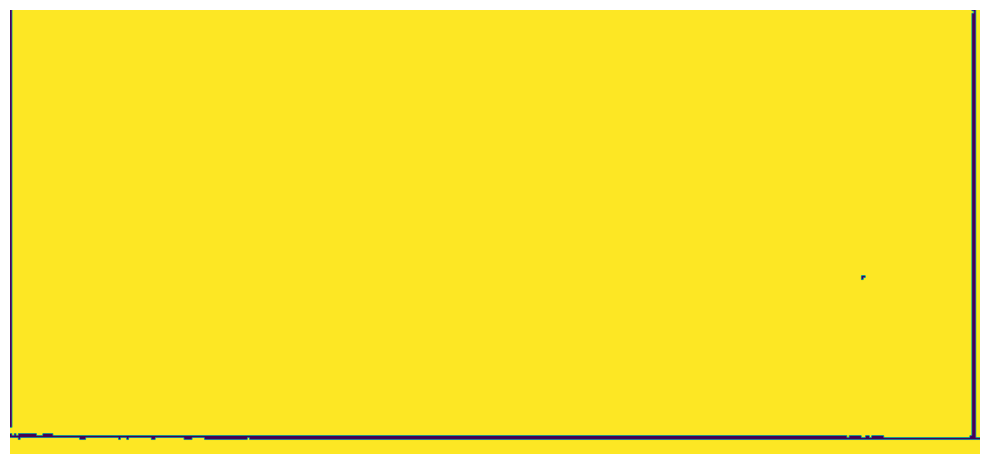

In [23]:
# Dans le cas où on a trouvé un contour
# ---------------------------------------------------
sig_titulaire,sig_rep_legal = divide_by_3(im_box,found_box)
show_image(sig_titulaire)
show_image(sig_rep_legal)

In [58]:
# Dans le cas où on a PAS trouvé de contour
# ---------------------------------------------------
# admettons que nous n'ayons pas trouvé de contour donc que la fonction 
# find_contours ait renvoyé l'image d'entrée im_rot.
"""found_box = False
im_box = im_rot.copy()

sig_titulaire,sig_rep_legal = divide_by_3(im_box,found_box)
show_image(sig_titulaire)
show_image(sig_rep_legal)"""

'found_box = False\nim_box = im_rot.copy()\n\nsig_titulaire,sig_rep_legal = divide_by_3(im_box,found_box)\nshow_image(sig_titulaire)\nshow_image(sig_rep_legal)'

### Algorithme signature_detect

Plusieurs modules : 

**LOADER:** 

On a modifié ce module comme expliqué dans l'intro, mais au final, j'ai recodé mon propre Loader (ie toutes les fonctions ci-dessus de pré-processing).On n'utilise donc pas le Loader de Signature detect.

**EXTRACTOR:**

- Les paramètres de ce module sont: 
    - outlier_weight: The weight of small outlier size
    - outlier_bias: The bias of small outlier size
    - amplfier: The amplfier calculates the big outlier size from the small one
    - min_area_size: The min region area size in the labeled image.
  
  
- On commence par labelliser l'image binaire avec measure.label de skimage  (https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label): on assigne la même valeur à toutes les zones connectés de l'image. On obtient ainsi une image divisée en régions de pixels connectés. Deux pixels sont connectés lorsqu'ils sont voisins et qu'ils ont la même valeur. On attribue également à chaque région de pixels connectés un nombre unique à l'aide d'un dictionnaire.
- On compte le nombre total de pixels de l'image labelisée càd le nombre de pixels connectés entre eux définissant les écritures de l'image noté total_pixels. On compte également le nombre de régions de pixels connectés de l'image noté nb_regions. 
- Pour chaque région de pixels connectés l'image, on regarde d'abord si elle est suffisamment grande càd si ragion.area > min_area_size. Ensuite, on calcule le pourcentage de remplissage de la région noté average=total_pixels/nb_region. On définit ensuite les valeurs suivantes :
    - small_size_outlier : utilisé comme valeur seuil pour éliminer les pixels + petits que small_size_outlier\
      small_size_outlier = average * outlier_weight + outlier_bias
      
    - big_size_outlier : utilisé comme valeur seuil pour éliminer les pixels + grands que big_size_outlier\
      big_size_outlier = small_size_outlier * self.amplfier
- On supprime de l'image labelisée les petites zones de pixels connectés < small_size_outlier.
- On supprime de l'image lablisée les grandes zondes de pixels connectés > big_size_outlier.
- On retourne l'image binaire modifiée.


***Résumé***: L'extractor enlève de l'image binaire les éléments qui sont trop grand ou trop petits pour correspondre à une signature. Si l'on arrive à détecter les contours, l'extractor n'est pas utilisé. Sinon, il est utilisé. Cependant, avec l'implémentation actuelle (sans Tesseract et donc sans détection de texte), l'algorithme ne trouvera pas la signature ci celle-ci est trop petite. 


**CROPPER:**

Le cropper permet de : 

- trouver les contours des éléments de l'image binaire passée en entrée (avec find_contours()). Les contours plus petits que min_region_size sont ignorés. Les contours sont ensuite triés par taille décroissante. Un contour est défini par [x,y,w,h] où (x,y) est le centre de la boîte, w la largueur et h la hauteur.
- Les contours triés sont ensuites transformés en régions avec boxes2regions(). Si les contours s'interceptent, alors ils sont fusionnés. Les bords des contours sont également coupés selon l'agument border_ratio.  Les régions sont des boîtes plus grandes (qui ont été fusionnés pour certaines) et sont également définies par [x,y,w,h].
- Enfin, l'image binaire est découpée selon les régions trouvées avec la fonction merge_regions_and_masks() (découpage selon les paramètres [x,y,w,h] de chaque boîte). La première région est retrounée est la plus grande et contient normalement la signature.

border_ratio : J'ai modifié la fonction cropper pour que la bordure de la première région trouvée soit supprimée avec l'argument border_ratio (ça ne le faisait pas). J'ai également redéfini la supression de bordure pour qu'elle soit centrée.

**JUDGER:**

Le judger permet de : 

- Lire la région retournée par le cropper (on lit la première région retournée donc celle contenant normalement la signature).
- On commence par déterminer si la région binaire en entrée est valide, c'est à dire si elle n'est pas de taille nulle et si elle ne contient pas que des 0 ou que des 255 (toute noire ou toute blanche).
- On regarde ensuite si la taille de la région correspond aux critères déterminés par l'argument size_ratio = [1,4] (valeur par défaut) : si ratio_image < size_ratio[0] ou ratio_image > size_ration[1] alors le judger détecte qu'il n'y a pas de signature, avec ratio_image = max(region.shape)/min(region.shape). 
- Enfin, on regarde le remplissage de l'image en fonction de l'argument pixel_ratio=[0.01,1] (valeur par défaut). Soit n_pix = le nombre de pixels à 0 / le nombre de pixels à 255. Si n_pix < pixel_ratio[0] ou n_pix > pixel_ratio[1], le judger détermine qu'il n'y a pas de signature. 

J'ai un peu modifié cette librairie dans la version v2 pour que ça m'affiche le pixel ratio pour que je puisse debugger.

In [24]:
def run_signature_detect_paper(im_bin,
                         found_box,
                         extractor_params={"outlier_weight":2,"outlier_bias":100,"amplfier":10,"min_area_size":1},
                         cropper_params = {"min_region_size":1e3,"border_ratio":0.01},
                         judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.01,1]},
                         verbose:bool=False,
                         debug:bool=False):
    
    """
    Cette fonction permet de regrouper toutes les étapes nécessaires 
    pour détecter la signature sur un pdf scanné à l'aide de la librairie 
    signature-detect. L'image doit au préalable avoir été binarisée. 
    >>> Utilise la fonction show_image()
    
    Input:
    -----
    - im_bin (np.array): image binaire sur laquelle détecter la signature. 
      L'image devrait avoir été pre-processed auparavant.
    - found_box (bool): si True les contours encadrant la signature ont été trouvés.
      Dans ce cas, on n'utilse pas l'Extractor. Si false, les contours n'ont pas été 
      trouvés et on utilse l'Extractor.
    - extractor_params (dict): extractor_params = {"outlier_weight":2,
      "outlier_bias":100,"amplfier":10,"min_area_size":1}. Contient les paramètres de
      l'Extractor.
    - cropper_params (dict): cropper_params = {"min_region_size":1e3,"border_ratio":0.01}
      Contient les paramètres du Cropper.
    - judger_params (dict): judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.01,1]}
      Contient les paramètres du Judger.
    - verbose (bool): si True, la description de l'Extractor, Cropper et Judger sont 
      affichés ainsi que des images.
    - debug (bool): si True, affiche les zones de pixels connectés trouvés pour 
      visualiser ce qu'il se passe.
    
    Ouput:
    ------
    - is_signed (bool): si True, le document est signé.
    
    ================================ Notes ================================
    La package signature-detect contient plusieurs modules résumés brièvement ici : 
    
    LOADER:
    Charge le pdf, le transforme en image et applique un pre-processing
    sur l'image pour obtenir une image binaire. 
    On n'utilise donc pas le Loader de signature-detect. On met en entrée
    une image déjà pre-processed par un équivalent du Loader que nous avons
    implémenté.

    EXTRACTOR:
    L'extractor enlève de l'image binaire les éléments qui sont trop grand ou trop petits pour 
    correspondre à une signature. Si l'on arrive à détecter les contours, l'extractor 
    n'est pas utilisé. Sinon, il est utilisé. 

    CROPPER:
    Le cropper découpe l'image binaire selon des régions de pixels connectés. 

    JUDGER:
    Le judger permet lit les régions données par le cropper et applique plusieurs 
    critères de taille et remplissage de la région pour déterminer si celle-ci 
    contient une signature.    
    =======================================================================
    
    Référence:
    ---------
    - tuto package signature-detect:
      https://github.com/EnzoSeason/signature_detection/blob/main/demo.ipynb
    """
    im = im_bin.copy()

    # =====================================
    # 1. EXTRACTOR
    # =====================================
    if not(found_box):
        # définition de Extractor
        extractor = Extractor(outlier_weight = extractor_params["outlier_weight"],
                              outlier_bias = extractor_params["outlier_bias"],
                              amplfier = extractor_params["amplfier"],
                              min_area_size = extractor_params["min_area_size"],
                              debug=debug)
        # suppression des régions de pixels connectés trop grandes ou trop petites
        im = extractor.extract(im)

        # affichage si verbose=True
        if verbose: 
            print(extractor)            
            print(">>> Image après Extractor:")
            show_image(im)

    # =====================================
    # 2. CROPPER
    # =====================================
    # définition du Cropper
    cropper = Cropper(min_region_size=cropper_params["min_region_size"],
                      border_ratio= cropper_params["border_ratio"])
    # découpage de l'image selon des régions de pixels connectés
    results = cropper.run(im)

    # affichage si verbose=True
    if verbose: 
        print(cropper)

    # =====================================
    # 3. JUDGER
    # =====================================
    # définition du Judger
    judger = Judger(size_ratio = judger_params["size_ratio"],
                    pixel_ratio = judger_params["pixel_ratio"],
                    debug = debug)

    #----- si results contient une valeur, il peut y avoir une signature
    if len(results)>0:
        # la première valeur de results est la région de pixels
        # connectés la plus grande et est supposée correspondre
        # à la signature
        signature = results[0]["cropped_mask"]
        # le judger détermine si il y a signature 
        is_signed = judger.judge(signature)
        
        # affichage si verbose=True
        if verbose:
            print(">>> Image après Cropper:")
            show_image(signature)

    #----- si results ne contient aucune valeur, il n'y a pas de signature    
    else:
        is_signed = False
    
    # affichage si verbose=True
    if verbose: 
        print(judger)
        print(">>> Document signé:", is_signed)
        
    return is_signed


Cropper
min_region_size = 1000.0
border_ratio = 0.01

pixel_ratio:  0.034487684245297336
>>> Image après Cropper:


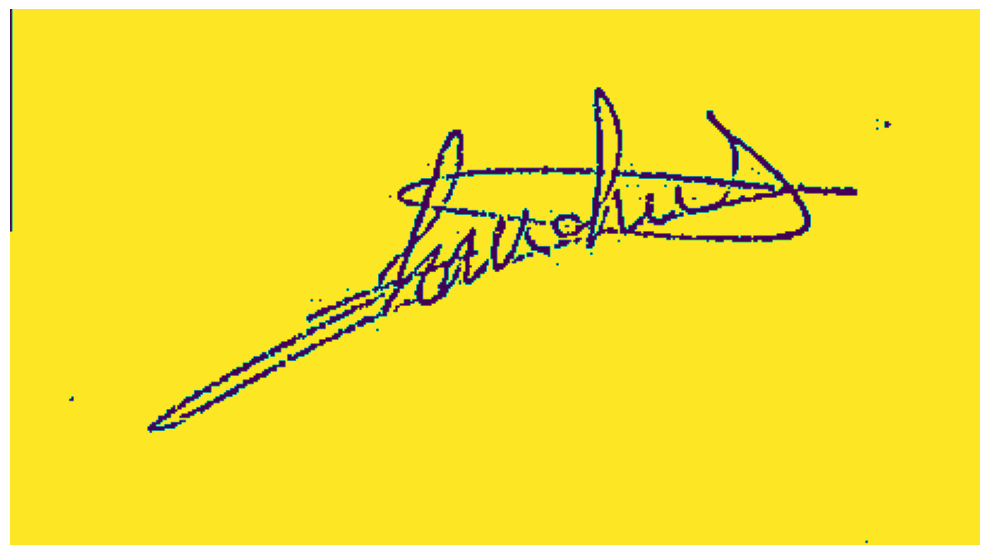


Judger
size_ratio = [1, 4]
pixel_ratio = [0.02, 1]

>>> Document signé: True

Cropper
min_region_size = 1000.0
border_ratio = 0.01

pixel_ratio:  0.002136752136752137
>>> Image après Cropper:


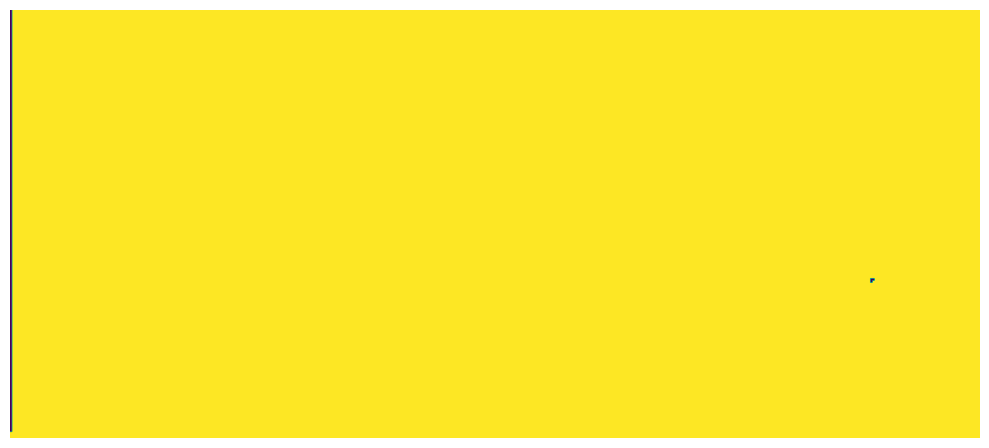


Judger
size_ratio = [1, 4]
pixel_ratio = [0.02, 1]

>>> Document signé: False


In [25]:
is_signed_titulaire = run_signature_detect_paper(
                        sig_titulaire,
                        found_box,
                        extractor_params={"outlier_weight":2,"outlier_bias":100,"amplfier":10,"min_area_size":1},
                        cropper_params = {"min_region_size":1e3,"border_ratio":0.01},
                        judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.02,1]},
                        verbose = True,
                        debug = True)

is_signed_rep_legal = run_signature_detect_paper(
                        sig_rep_legal,
                        found_box,
                        extractor_params={"outlier_weight":2,"outlier_bias":100,"amplfier":10,"min_area_size":1},
                        cropper_params = {"min_region_size":1e3,"border_ratio":0.01},
                        judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.02,1]},
                        verbose = True,
                        debug = True)

In [ ]:
"""is_signed_eai = run_signature_detect_paper(
                        im_box,
                        found_box,
                        extractor_params={"outlier_weight":2,"outlier_bias":100,"amplfier":10,"min_area_size":1},
                        cropper_params = {"min_region_size":1e3,"border_ratio":0.01},
                        judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.02,1]},
                        verbose = True,
                        debug = True)"""

In [61]:
def conclusion(is_signed_1:bool,is_signed_2:bool,verbose:bool=False):
    """
    Cette fonction très simple retoure is_signed=True, si 
    is_signed_titulaire ou is_signed_rep_legal est True.
    """
    
    if is_signed_1 or is_signed_2:
        is_signed=True
    else:
        is_signed=False
        
    if verbose:
        print("Document signé:",is_signed)
        
    return is_signed

In [62]:
is_signed = conclusion(is_signed_titulaire,is_signed_rep_legal,verbose=True)

Document signé: True


### Signature numérique

Il peut y avoir des documents numériques qui sont signés manuellement. Si `text` a une longueur positive et si on ne trouve pas de signature numérique, tenter la détection de signature scannée.

In [3]:
import fitz #pip install pymupdf

In [14]:
# On se place dans le dossier des signatures numériques
# ---------------------------------------------------
# path = PATH_DATA_LEA_N
path = "C:/Users/A3193307/projet_signature/All_LEA_100_version2"
os.chdir(path)
!ls

#pdf_name = "007929293"
list_pdf_num = ["13135_006818897_SLEA_2022-04-02_0083cfc2-7143-4305-a017-a2c7b34e8e94",
               "13135_006864695_SLEA_2023-03-18_e4d19614-a173-4e11-af8a-4af051f57d2b",
               "13135_006779045_SLEA_2022-01-28_3f8fb817-c29b-4e91-927f-f7ddbcd3882b",
               "13135_006692940_SLEA_2023-03-22_96f74e24-65e5-42d2-870d-c7c64d8e2852",
                "13135_006872827_SLEA_2022-06-11_5f2d9524-c318-41e4-98d1-d7fe21bb8e91",
                "13135_006760143_SLEA_2022-01-28_5d61c1f9-c34f-4e2e-a613-1129d3f7ff85",
                "13135_006668462_SLEA_2022-03-14_5a042b0d-4cd8-491f-ba03-6f1092b332c0",
                "13135_006806740_SLEA_2022-06-13_7ef68e50-5f76-453c-a89e-167504d15260",
                "13135_006749816_SLEA_2022-03-14_65b6e7ec-6c73-4517-8fdc-af7079c8c7d0",
                "13135_006868121_SLEA_2022-06-15_82393b68-528c-438d-8cf3-b7c7c4d26f18",
                 "13135_006683280_SLEA_2022-11-15_0ee0a32f-dfee-446d-9d31-1beb01841b69"]

list_pdf_pap = ["13135_006642241_SLEA_2022-07-28_ACQ13135-3101029-1659012096371-17865",
               "13135_006644064_SLEA_2022-07-13_ACQ13135-3192229-1657717751912-74360",
               "13135_006646602_SLEA_2022-01-21_ACQ13135-3190908-1642761373133-26246",
               "13135_006647588_SLEA_2022-03-11_ACQ13135-3100897-1646988816431-70894",
               "13135_006864179_SLEA_2022-01-29_ACQ13135-3101094-1643455375264-25167",
               "13135_006698900_SLEA_2022-06-21_ACQ13135-3103536-1655806798599-34573"]

13135_006642241_SLEA_2022-07-28_ACQ13135-3101029-1659012096371-17865.pdf
13135_006644064_SLEA_2022-07-13_ACQ13135-3192229-1657717751912-74360.pdf
13135_006644299_SLEA_2022-01-21_ACQ13135-3100833-1642783931468-48718.pdf
13135_006646602_SLEA_2022-01-21_ACQ13135-3190908-1642761373133-26246.pdf
13135_006647588_SLEA_2022-03-11_ACQ13135-3100897-1646988816431-70894.pdf
13135_006648493_SLEA_2022-06-15_ACQ13135-3139910-1655299761273-66126.pdf
13135_006648838_SLEA_2022-01-11_ACQ13135-3101099-1641899300709-21316.pdf
13135_006648838_SLEA_2022-03-16_ACQ13135-3101099-1647425771467-59367.pdf
13135_006649041_SLEA_2023-03-23_ACQ13135-3103045-1679578579910-10664.pdf
13135_006649081_SLEA_2023-02-24_ACQ13135-3103500-1677254202859-63376.pdf
13135_006649929_SLEA_2022-03-12_ACQ13135-3103500-1647073244109-73546.pdf
13135_006650191_SLEA_2022-01-11_ACQ13135-3101235-1641894295423-19897.pdf
13135_006652372_SLEA_2023-01-12_ACQ13135-3192520-1673540711400-12838.pdf
13135_006665216_SLEA_2022-02-10_ACQ13135-3139355-16

In [27]:
def is_numerical(path_pdf):
    """
    Cette fonction permet de déterminer si un document pdf est numérique 
    ou scanné. 
    
    Input:
    -----
    - path_pdf (strig): chemin absolu vers le document pdf à vérifier.

    Ouput:
    ------
    - is_num (bool): si True, le document est numérique. Sinon, il est scanné.
    
    Reference:
    ---------
    - lecture d'un document avec fitz:
      https://pymupdf.readthedocs.io/en/latest/recipes-text.html
    """
    
    text = ""
    
    # ouverture du document
    doc = fitz.open(path_pdf)
    
    #On recherche une page pour laquelle on peut lire du texte.
    #Une fois la page trouvée, on arrête la recherche
    is_num=False
    i=0
    while not is_num and i<len(doc):
        page = doc[i]
        text += page.get_text(sort=True) #.encode("utf8") #encode return bytes
        if len(text)>0:
            is_num = True
        else:
            i+=1
    # ferme document
    doc.close()
        
    """
    text = ""
    
    # ouverture du document
    doc = fitz.open(path_pdf)
    
    # itère sur chaque page et récupère le texte
    for page in doc:  
        text += page.get_text(sort=True) #.encode("utf8") #encode return bytes
    
    # ferme document
    doc.close()
    
    # Si le document possède du texte...
    if len(text) > 0:
        #... alors le document est numérique.
        is_num = True 
    # Si le document ne possède pas de texte...
    else:
        #... alors le document est papier.
        is_num = False
    """
        
    return is_num

In [29]:
#is_num = is_numerical(path +"\\"+pdf_name+".pdf" )
#print("is_num:",is_num)

for pdf_name in list_pdf_num:
    is_num = is_numerical(path +"\\"+pdf_name+".pdf")
    print("is_num:",is_num)

is_num: True
is_num: True
is_num: True
is_num: True
is_num: True
is_num: True
is_num: True
is_num: True
is_num: True
is_num: True
is_num: True


In [19]:
def run_signature_detect_num(path_pdf):
    """
    Cette fonction permet de détecter si un document pdf numérique
    a été signé. 
    
    Input:
    -----
    - path_pdf (strig): chemin absolu document pdf à vérifier.

    Ouput:
    ------
    - is_signed (bool): si True, le document a été signé
    
    ================================ Notes ================================
    function get_sigflags(): PDF only: Return whether the document contains 
    signature fields. This is an optional PDF property: if not present (return value -1),
    no conclusions can be drawn – the PDF creator may just not have bothered using it.
    
    Returns
    -1: not a Form PDF / no signature fields recorded / no SigFlags found.
    1: at least one signature field exists.
    3: contains signatures that may be invalidated if the file is saved (written)
    in a way that alters its previous contents, as opposed to an incremental update.
    =======================================================================
    
    Reference:
    ---------
    - forum détection signature pdf:
      https://github.com/pymupdf/PyMuPDF/issues/326
    - fonction get_sigflags:
      https://pymupdf.readthedocs.io/en/latest/document.html#Document.get_sigflags
    """
    # ouvre le document
    doc = fitz.open(path_pdf) 
    # regarde si le document est signé
    sig = doc.get_sigflags()
    # ferme le document
    doc.close()
    # met à jour la variable is_signed
    if sig == -1:
        is_signed = False
    else:
        is_signed = True
    return is_signed

In [21]:
#is_signed = run_signature_detect_num(path +"\\"+pdf_name+".pdf")
#print("is_signed:", is_signed)

for pdf_name in list_pdf_num:
    is_signed = run_signature_detect_num(path +"\\"+pdf_name+".pdf")
    print("is_signed:", is_signed)

is_signed: True
is_signed: True
is_signed: True
is_signed: True
is_signed: True
is_signed: True
is_signed: True
is_signed: True
is_signed: True
is_signed: True
is_signed: True
